In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import yfinance as yf 
from scipy.optimize import root
from scipy.stats import norm, t

import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
formatter = mdates.DateFormatter("%Y-%m-%d")

# **KVM MODEL TO CALCULATE DEFAULT PROBABILITIES**


## **Download financial statements from the SEC EDGAR website**


<font size="3"> The SEC has a comprehensive database where you can download the financial statements for public listed companies. It is called EDGAR and you can download 10-Q or 10-K reports easily. In the following script you can watch how to do it. <br><br> 

In [2]:
#DOWNLOAD FINANCIAL STATEMENTS
#You can search cik codes in the following link -> https://www.sec.gov/edgar/searchedgar/cik.htm

headers = { 'User-Agent': 'Mozilla/5.0', } 

#CIK for Bed, Bath and Beyond
CIK = '0000886158' # -> Bed, Bath and Beyond


#Download information
download = requests.get('https://data.sec.gov/api/xbrl/companyfacts/CIK'+CIK+'.json', stream=True, headers = headers)
fin_statment = download.json()

#Extract US-Gaap accounting ledgers
us_gaap_concepts = list(fin_statment['facts']['us-gaap'].keys())

In [3]:
#Liabilities
Liabilities_list = fin_statment['facts']['us-gaap']['Liabilities']['units']['USD']
Liabilities_df = pd.DataFrame(Liabilities_list)
Liabilities_df['end'] = pd.to_datetime(Liabilities_df['end'])
Liabilities_df = Liabilities_df.dropna()
Liabilities_df = Liabilities_df[Liabilities_df['frame'].str.contains('CY')]
Liabilities_df = Liabilities_df[Liabilities_df['end']<=datetime(2023, 3, 31)]


#LiabilitiesCurrent
LiabilitiesCurrent_list = fin_statment['facts']['us-gaap']['LiabilitiesCurrent']['units']['USD']
LiabilitiesCurrent_df = pd.DataFrame(LiabilitiesCurrent_list)
LiabilitiesCurrent_df['end'] = pd.to_datetime(LiabilitiesCurrent_df['end'])
LiabilitiesCurrent_df = LiabilitiesCurrent_df.dropna()
LiabilitiesCurrent_df = LiabilitiesCurrent_df[LiabilitiesCurrent_df['frame'].str.contains('CY')]
LiabilitiesCurrent_df = LiabilitiesCurrent_df[LiabilitiesCurrent_df['end']<=datetime(2023, 3, 31)]

#CommomStockSharesOutstanding
CommonStockSharesOutstanding_list = fin_statment['facts']['us-gaap']['CommonStockSharesOutstanding']['units']['shares']
CommonStockSharesOutstanding_df = pd.DataFrame(CommonStockSharesOutstanding_list)
CommonStockSharesOutstanding_df['end'] = pd.to_datetime(CommonStockSharesOutstanding_df['end'])
CommonStockSharesOutstanding_df = CommonStockSharesOutstanding_df.dropna()
CommonStockSharesOutstanding_df = CommonStockSharesOutstanding_df[CommonStockSharesOutstanding_df['frame'].str.contains('CY')]
CommonStockSharesOutstanding_df = CommonStockSharesOutstanding_df[CommonStockSharesOutstanding_df['end']<=datetime(2023, 3, 31)]

## **Download the price history**


<font size="3"> You can use the yahoo finance API to download the company's stock's price history. In pandas it is also very easy to calculate the historic volatility. Both are shown un the following script <br><br> 

In [4]:
#DOWNLOAD HISTORIC STOCK PRICES
Ticker = 'BBBY'

prices = yf.Ticker(Ticker)
prices_hist = prices.history(period="max")
df = prices_hist
df.reset_index(inplace=True)
df = df[df['Date']>=datetime(1999, 12, 31)]
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.date
df['Date'] = pd.to_datetime(df['Date'])

#Volatility calculations
df['return'] = df['Close'][1:].values/df['Close'][:-1]-1
df['volatility']=df['return'].rolling(window=252).std()*252**0.5

## **Create a single dataframe**


<font size="3"> Now we order all the information into a single dataframe. We need the information of current and non current liabilities, the number of shares and the price to calculate market capitalizarion and the volatility of the stock price <br><br> 

In [5]:
#Create a single DataFrame

#Merge number 1
df2 = pd.merge(Liabilities_df,
                        LiabilitiesCurrent_df[['end','val']], 
                        left_on='end',
                        right_on='end',              
                        )
#Merge number 2
df2 = pd.merge(df2,
                CommonStockSharesOutstanding_df[['end','val']], 
                left_on='end',
                right_on='end',              
                        )

df2 = df2.rename(columns={'end':'date',
                          'val_x':'liabilities',
                          'val_y':'liabilitiescurrent',
                          'val':'shares'
                                        })

df2 = df2[['date','liabilities','liabilitiescurrent','shares']]


#Merge number 3
df_final = pd.merge_asof(df2,
                        df[['Date','Close','volatility']], 
                        left_on='date',
                        right_on='Date',                         
                        tolerance = pd.Timedelta('3d'))  


df_final = df_final.rename(columns={'Close':'close'})


#Final calculations
df_final['mkt_cap'] = df_final['shares']*df_final['close']
df_final['liabilitiesnoncurrent'] = df_final['liabilities']-df_final['liabilitiescurrent']
df_final = df_final[['date','mkt_cap','volatility','liabilities','liabilitiescurrent','liabilitiesnoncurrent']]

#Correct the market cap for this date
df_final['mkt_cap'].iloc[34] = df_final['mkt_cap'].iloc[34]*1000

## **Iteration to calculate assets value and assets volatility**


<font size="3"> Finally we need to calculate assets value and assets volatility. With these 2 quantities we can calculate the measure d2. And using d2 we can calculate the 1Y expected default probability for the company we are interested in. In the original KVM model this cumulative probability function is empirically estimated using propietary data. Here I used a t-student distribution for the sake of simplicity. <br><br> 

In [6]:
#Iteration algorithm

company_data = pd.DataFrame().T

for i in range (0,df_final.shape[0]):
    equity_vol = df_final['volatility'].iloc[i]
    market_cap = df_final['mkt_cap'].iloc[i]
    liabilities_current = df_final['liabilitiescurrent'].iloc[i]
    liabilities_noncurrent = df_final['liabilitiesnoncurrent'].iloc[i]   
    date = df_final['date'].iloc[i]
    
    initial_assets = market_cap + liabilities_current + liabilities_noncurrent
    assets = initial_assets
    liabilities = liabilities_current + liabilities_noncurrent
    dp = liabilities_current + 0.5*liabilities_noncurrent      #default point
    initial_asset_vol = equity_vol
    asset_vol = initial_asset_vol
    equity = market_cap
    r = 0.05
    T = 1
    epsilon = 1
    
    d1 = (np.log(assets/liabilities)+(r+0.5*asset_vol**2)*T)/(asset_vol*T**0.5)
    d2 = (np.log(assets/liabilities)+(r-0.5*asset_vol**2)*T)/(asset_vol*T**0.5)
    
    def function1(x):
        return x - assets*norm.cdf(d1) + np.exp(-r*T)*norm.cdf(d2)
    
    def function2(x):
        return equity_vol - norm.cdf(d1)*(assets/equity)*x
    
    while epsilon > 0.00001:
        sol2 = root(function2,asset_vol)
        sol1 = root(function1,assets)
        
        equity = sol1.x[0]
        asset_vol_new = sol2.x[0]
        epsilon = asset_vol_new - asset_vol
        asset_vol = asset_vol_new
        
    new_list = []
    new_list.append(date)
    new_list.append(assets)
    new_list.append(liabilities)
    new_list.append(liabilities_current)
    new_list.append(liabilities_noncurrent)
    new_list.append(equity_vol)
    new_list.append(asset_vol)
    new_list.append(market_cap)
    new_list.append(d1)
    new_list.append(d2)
    new_list.append(t.cdf(-d2,5))  #t-student probability - proxy
    
    company_data = company_data.append(pd.DataFrame(new_list).T)
    
company_data = company_data.rename(columns={0:'date',
                                                1:'assets',
                                                2:'liabilities',
                                                3:'liabilities_current',
                                                4:'liabilities_noncurrent',
                                                5:'equity_vol',
                                                6:'asset_vol',
                                                7:'market_cap',
                                                8:'d1',
                                                9:'d2',
                                                10:'default_prob',                                                
                                               })

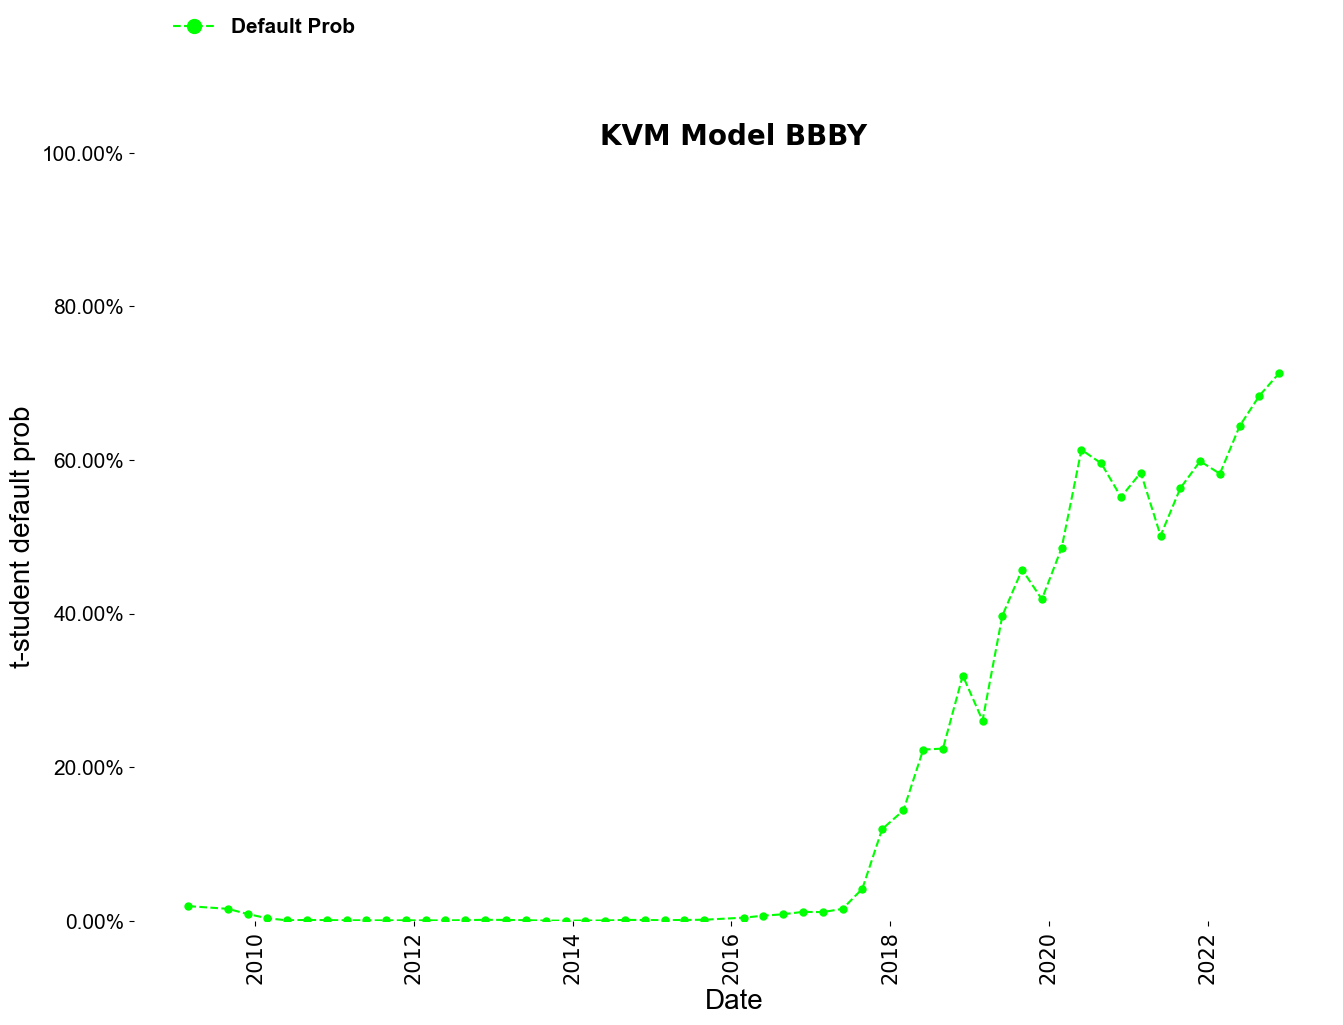

In [7]:
#Create chart
fig = plt.figure()
ax1 = plt.subplot(111,frameon=False)

company_data.sort_values('date',ascending=True,inplace=True)
font = font_manager.FontProperties(family='Arial',weight='bold', style='normal', size=15)

ax1.plot(company_data['date'],company_data['default_prob']*100,marker='o', linestyle='dashed',color='lime',label='Default Prob',markersize=5)
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.2, 1.2),ncol=10,markerscale=2)
ax1.set_xlabel('Date',fontname = "Arial", fontsize=20,color='black')
ax1.set_ylabel('t-student default prob',fontname = "Arial", fontsize=20,color='black')
ax1.tick_params(axis='y', color = 'black', labelcolor='black')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax1.axis([None, None, 0, 100])
plt.xticks(rotation=90)

plt.title('KVM Model ' + Ticker,fontsize=20,weight="bold")
plt.yticks(fontname = "Arial",fontsize=15)
plt.subplots_adjust(wspace = 0.3,hspace = 0.8,bottom=0.1, right=2.0, top=1.7)
    
plt.show()

> *What we have to learn to do, we learn by doing*. *Aristotle*

<font size="3">
Follow me on <a href="https://co.linkedin.com/in/andres-gomez-hernandez" target="_blank">Linkedin</a> for topics about quantitative finance, data science and emerging markets.
</font>